# Introduction to scvi-tools in R

In this introductory tutorial, we go through the different steps of an scvi-tools workflow. It is the R version of [this]("https://docs.scvi-tools.org/en/latest/tutorials/notebooks/quick_start/api_overview.html") python tutorial.

While we focus on scVI in this tutorial, the API is consistent across all models. 

In [1]:
library(reticulate)
library(anndataR)
library(ggplot2)
library(IRdisplay)

Before we use reticulate, we will need to point it to the correct conda env we use for the analysis

In [2]:
use_condaenv("base", required = TRUE)

### Import Python libraries with reticulate

In [3]:
sc <- import('scanpy', convert = FALSE)
scvi <- import("scvi", convert = FALSE)

In [4]:
scvi$`__version__`

'1.4.0.post1'

In [5]:
scvi$settings$seed=42L

Load a subsampled version of the heart cell atlas dataset directly from scvi, like the python tutorial:

In [6]:
adata = scvi$data$heart_cell_atlas_subsampled()
adata

AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

Apply scanpy preprocessing functions directly:

In [7]:
sc$pp$filter_genes(adata, min_counts=3L)
sc$pp$filter_cells(adata, min_genes = 200L)
adata$layers["counts"] = adata$X$copy()  # preserve counts
sc$pp$normalize_total(adata, target_sum = 1e4)
sc$pp$log1p(adata)
adata$raw = adata  # freeze the state in `.raw`

None

None

None

None

Select highly variable genes

In [8]:
sc$pp$highly_variable_genes(
    adata,
    n_top_genes=r_to_py(1200),
    subset=TRUE,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

None

In [9]:
adata

AnnData object with n_obs × n_vars = 18641 × 1200
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'cell_type_colors', 'log1p', 'hvg'
    layers: 'counts'

### Creating and training a model

In [10]:
# run setup_anndata
scvi$model$SCVI$setup_anndata(adata,
                            layer="counts",
                            categorical_covariate_keys=c("cell_source", "donor"),
                            continuous_covariate_keys=c("percent_mito", "percent_ribo")
                             )

None

In [11]:
# create the model
model = scvi$model$SCVI(adata)
model

In [12]:
# train the model
model$train(max_epochs = 400L)

None

In [13]:
str(py_to_r(model$registry))

List of 6
 $ scvi_version     : chr "1.4.0.post1"
 $ model_name       : chr "SCVI"
 $ setup_args       :List of 6
  ..$ layer                     : chr "counts"
  ..$ batch_key                 : NULL
  ..$ labels_key                : NULL
  ..$ size_factor_key           : NULL
  ..$ categorical_covariate_keys: chr [1:2] "cell_source" "donor"
  ..$ continuous_covariate_keys : chr [1:2] "percent_mito" "percent_ribo"
 $ field_registries :defaultdict(<class 'dict'>, {'X': {'data_registry': {'attr_name': 'layers', 'attr_key': 'counts'}, 'state_registry': {'n_obs': 18641, 'n_vars': 1200, 'column_names': array(['ISG15', 'TNFRSF18', 'VWA1', ..., 'ITGB2', 'S100B', 'MT-ND4'],
      dtype=object)}, 'summary_stats': {'n_vars': 1200, 'n_cells': 18641}}, 'batch': {'data_registry': {'attr_name': 'obs', 'attr_key': '_scvi_batch'}, 'state_registry': {'categorical_mapping': array([0]), 'original_key': '_scvi_batch'}, 'summary_stats': {'n_batch': 1}}, 'labels': {'data_registry': {'attr_name': 'obs', 'att

### Show trainning curves

In [14]:
elbo_train <- py_to_r(model$history[['elbo_train']])
elbo_train$epoch = as.numeric(row.names(elbo_train))
elbo_train$elbo_train <- as.numeric(unlist(elbo_train$elbo_train))

In [15]:
head(elbo_train)

,elbo_train,epoch
,<dbl>,<dbl>
0,399.2092,0
1,343.5973,1
2,336.7948,2
3,333.0187,3
4,329.7122,4
5,327.3822,5


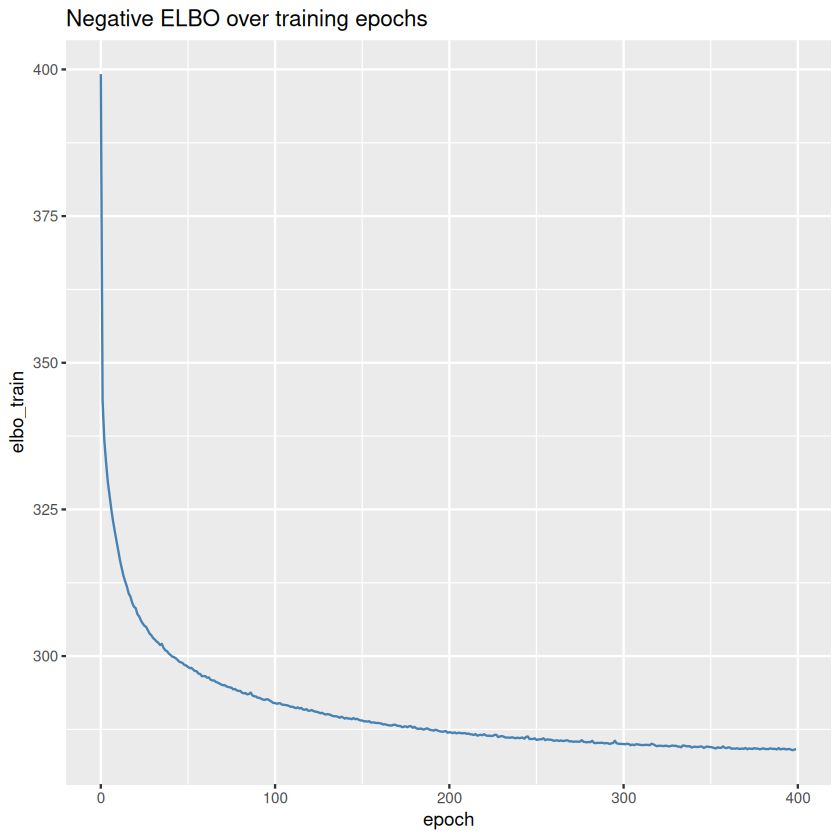

In [16]:
ggplot(elbo_train, aes(x = epoch, y = elbo_train)) +
  geom_line(color = "steelblue") +
  labs(title = "Negative ELBO over training epochs")

### Saving and loading

In [17]:
model_dir = file.path(getwd(), "scvi_model")
model$save(model_dir, overwrite=TRUE)

None

In [18]:
model = scvi$model$SCVI$load(model_dir, adata=adata)
model

### Obtaining model outputs

In [19]:
SCVI_LATENT_KEY = "X_scVI"

latent = model$get_latent_representation()
adata$obsm[SCVI_LATENT_KEY] = latent
latent$shape

(18641, 10)

In [20]:
adata_subset = adata[adata$obs$cell_type == "Fibroblast"]
latent_subset = model$get_latent_representation(adata_subset)
latent_subset$shape

(2446, 10)

In [21]:
denoised = py_to_r(model$get_normalized_expression(adata_subset, library_size=1e4))
denoised[c(1:6),c(1:6)]

,ISG15,TNFRSF18,VWA1,HES5,SPSB1,ANGPTL7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.7888508,0.0119431289,1.1120404,0.018676627,4.860909,0.07145255
GAGTCATTCTCCGTGT-1-HCAHeart8287128,4.9257708,0.0007238826,2.9720101,0.010875043,23.505468,0.05364634
CCTCTGATCGTGACAT-1-HCAHeart7702881,1.2384006,0.1348758042,1.2358764,0.005328822,2.995464,0.21579888
CGCCATTCATCATCTT-1-H0035_apex,0.1494295,0.0366671458,3.6661482,0.002467821,4.662594,0.23152569
TCGTAGAGTAGGACTG-1-H0015_septum,0.4851573,0.0979742408,0.3467574,0.094333917,10.356930,0.28906620
AAGTCTGCACCGATAT-1-HCAHeart7833854,1.8448507,0.1164853349,3.3415871,0.002791890,7.842077,0.82429951


In [22]:
SCVI_NORMALIZED_KEY = "scvi_normalized"

adata$layers[SCVI_NORMALIZED_KEY] = model$get_normalized_expression(library_size=10e4)

### Visualization without batch correction

In [23]:
# run PCA then generate UMAP plots
sc$tl$pca(adata)

None

In [24]:
sc$pp$neighbors(adata, n_pcs=30L, n_neighbors=20L) #note for the usage of "L" for integer

None

In [25]:
sc$tl$umap(adata, min_dist=0.3)

None

None

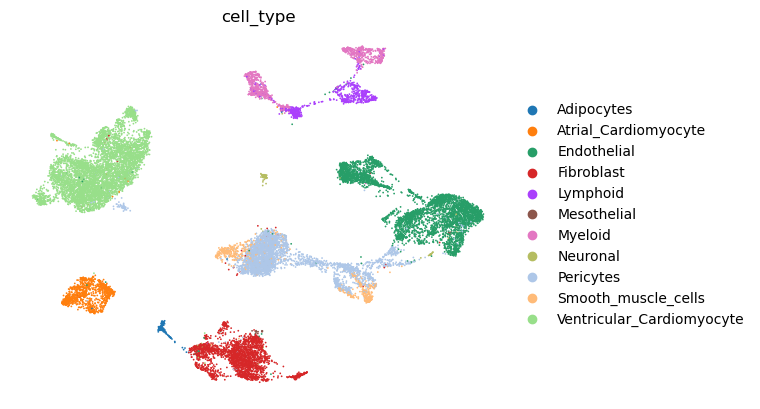

In [26]:
fig1 = sc$pl$umap(
    adata,
    color="cell_type",
    frameon=FALSE,
    return_fig=TRUE,
    show = FALSE
)
#We will use the saved file in order to plot in R notebook (might not directly render from the scanpy umap function)
fig1$savefig("pca_cell_type.png", bbox_inches="tight")
display_png(file = "pca_cell_type.png", width = 800, height = 600)

None

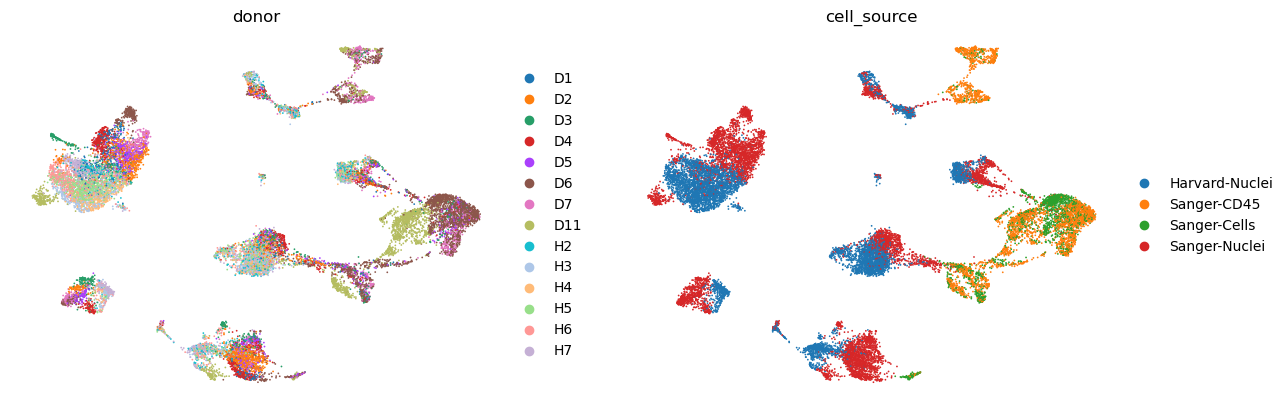

In [27]:
fig2 = sc$pl$umap(
    adata,
    color=c("donor", "cell_source"),
    ncols=2L,
    frameon=FALSE,
    return_fig=TRUE,
    show = FALSE
)
fig2$savefig("pca_donor_source.png", bbox_inches="tight")
display_png(file = "pca_donor_source.png", width = 1400, height = 1200)

### Visualization with batch correction (scVI)

In [28]:
# use scVI latent space for UMAP generation
sc$pp$neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc$tl$umap(adata, min_dist=0.3)

None

None

None

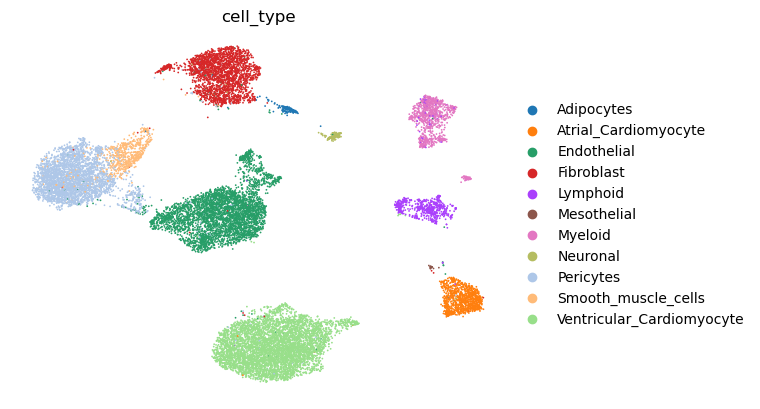

In [29]:
fig3 = sc$pl$umap(
    adata,
    color="cell_type",
    frameon=FALSE,
    return_fig=TRUE,
    show = FALSE
)
fig3$savefig("scvi_cell_type.png", bbox_inches="tight")
display_png(file = "scvi_cell_type.png", width = 800, height = 600)

None

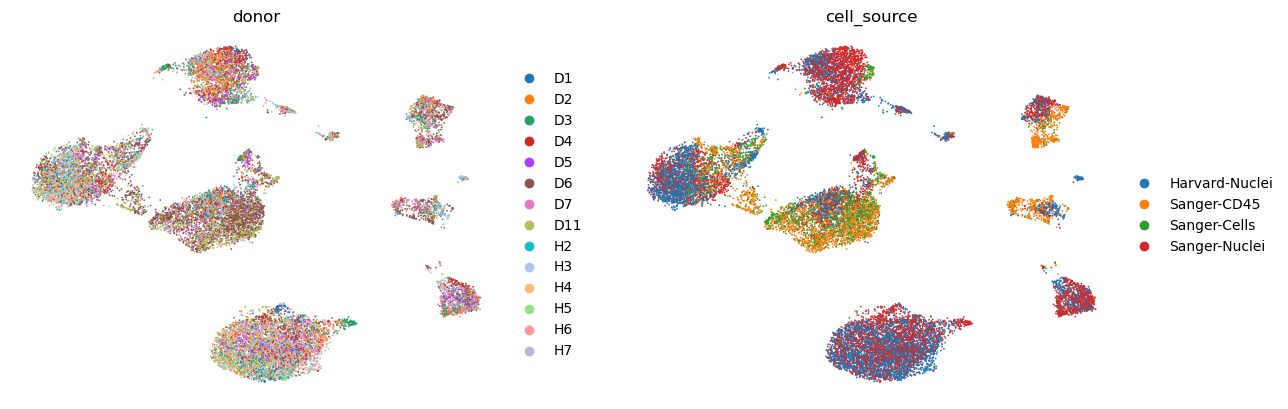

In [30]:
fig4 = sc$pl$umap(
    adata,
    color=c("donor", "cell_source"),
    ncols=2L,
    frameon=FALSE,
    return_fig=TRUE,
    show = FALSE
)
fig4$savefig("scvi_donor_source.png", bbox_inches="tight")
display_png(file = "scvi_donor_source.png", width = 1400, height = 1200)

### Clustering on the scVI latent space

In [31]:
# neighbors were already computed using scVI
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc$tl$leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)

None

None

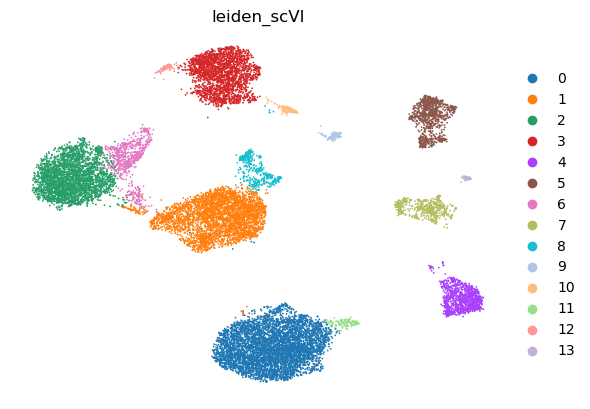

In [32]:
fig5 = sc$pl$umap(
    adata,
    color=SCVI_CLUSTERS_KEY,
    frameon=FALSE,
    return_fig=TRUE,
    show = FALSE
)
fig5$savefig("scvi_leiden_cluster.png", bbox_inches="tight")
display_png(file = "scvi_leiden_cluster.png", width = 800, height = 600)

### Differential expression

In [33]:
de_df = py_to_r(model$differential_expression(
    groupby="cell_type", group1="Endothelial", group2="Fibroblast"
))
head(de_df)

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison,group1,group2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
EGFL7,0.9980,0.0020,6.212601,0.008562270,3.754362e-04,2.3767791,0.036794767,0.7415430,0.025756337,89.50991,1.1710879,Endothelial vs Fibroblast,Endothelial,Fibroblast
VWF,0.9976,0.0024,6.029880,0.016483497,6.488101e-04,5.0725632,0.054374505,0.8082258,0.032297629,169.69870,2.2100585,Endothelial vs Fibroblast,Endothelial,Fibroblast
PECAM1,0.9974,0.0026,5.949637,0.005570970,5.923296e-04,2.0659840,0.075633690,0.6539304,0.054374489,60.61557,3.4050260,Endothelial vs Fibroblast,Endothelial,Fibroblast
SOX17,0.9956,0.0044,5.421739,0.001486544,2.656643e-05,0.7843711,0.006541292,0.3076174,0.004497138,17.12826,0.1858679,Endothelial vs Fibroblast,Endothelial,Fibroblast
STC1,0.9942,0.0058,5.144079,0.001763363,3.538079e-05,0.7853462,0.004088308,0.1988318,0.003270646,17.15776,0.1948121,Endothelial vs Fibroblast,Endothelial,Fibroblast
CYYR1,0.9936,0.0064,5.045035,0.003264735,2.135453e-04,0.9250352,0.017579721,0.4623996,0.011856092,36.28695,0.6462995,Endothelial vs Fibroblast,Endothelial,Fibroblast


In [34]:
de_df = py_to_r(model$differential_expression(groupby="cell_type", mode="change"))
head(de_df)

Warning message in py_to_r.pandas.core.frame.DataFrame(model$differential_expression(groupby = "cell_type", :
“index contains duplicated values: row names not set”


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,⋯,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<chr>
1,0.9990,0.0010,6.906745,0.028263256,1.929233e-04,9.363214e-06,0.25,7.635361,7.650973,2.310794,⋯,17.372416,0.035791390,0.8965517,0.031520329,280.35031,1.5660578,TRUE,Adipocytes vs Rest,Adipocytes,Rest
2,0.9974,0.0026,5.949637,0.011404380,1.613644e-04,9.363214e-06,0.25,6.560994,6.641238,2.107703,⋯,7.062068,0.025086449,0.8413793,0.022166955,129.08200,1.0845219,TRUE,Adipocytes vs Rest,Adipocytes,Rest
3,0.9964,0.0036,5.623212,0.002310156,2.986398e-05,9.363214e-06,0.25,7.686715,7.257122,3.371668,⋯,1.386207,0.002649222,0.4620690,0.002595156,22.76950,0.1100937,TRUE,Adipocytes vs Rest,Adipocytes,Rest
4,0.9956,0.0044,5.421739,0.004022333,4.849749e-05,9.363214e-06,0.25,7.317138,7.287269,2.508050,⋯,2.799999,0.004379326,0.8068966,0.004325260,52.92854,0.1964442,TRUE,Adipocytes vs Rest,Adipocytes,Rest
5,0.9952,0.0048,5.334326,0.003781068,3.304044e-05,9.363214e-06,0.25,8.007197,7.646867,3.393191,⋯,2.020689,0.002811420,0.5379310,0.002757353,28.45890,0.1279225,TRUE,Adipocytes vs Rest,Adipocytes,Rest
6,0.9948,0.0052,5.253881,0.004146528,3.967208e-05,9.363214e-06,0.25,7.130344,7.213494,2.497959,⋯,2.682757,0.005028114,0.5931034,0.004865917,43.61410,0.1941209,TRUE,Adipocytes vs Rest,Adipocytes,Rest


In [35]:
sc$tl$dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

None

### Session Info Summary

In [36]:
#reticulate::py_last_error()

In [37]:
sI <- sessionInfo()
sI$loadedOnly <- NULL
print(sI, locale=FALSE)

R version 4.3.3 (2024-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 24.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.12.0 
LAPACK: /opt/anaconda3/lib/libmkl_rt.so.2;  LAPACK version 3.10.1

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] IRdisplay_1.1     ggplot2_4.0.0     anndataR_1.1.0    reticulate_1.44.0
